In [1]:
# In questo juoyter notebook si mostra come implementare le tecniche di calibrazione
# mostrate nel tutorial https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html
# per backend che non supportano Pulse.
# A questo fine, sono state apportate al tutorial le minime modifiche necessarie.

In [2]:
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

import numpy as np

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='uni-milano-bicoc-1', project='main')

In [11]:
#Scelta del backend di lavoro
backend = provider.get_backend('ibmq_jakarta')
backend_config = backend.configuration()

In [12]:
dt = backend_config.dt
backend_defaults = backend.defaults()

GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0   # qubit che studiamo
mem_slot = 0    # Memory slot

# Centro della finestra di sweep. Frequenza espressa in Hertz
qubit_freq = backend_defaults.qubit_freq_est[qubit]

# Fattore di scala (per comodità)
scale_factor = 1e-14

# Siccome i samples devono essere in numero multiplo di 16, definisco una funzione
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.010 * us                            # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

In [13]:
print(f"Qubit {qubit} has an estimated frequency of {qubit_freq / GHz} GHz.")

Qubit 0 has an estimated frequency of 5.236358788120644 GHz.


In [14]:
#CALIBRATING AND USING A PI_PULSE ( 3 )

In [15]:
# Rabi experiment parameters
num_rabi_points = 60

# Drive amplitude values to iterate over: 60 amplitudes evenly spaced from 0 to 0.98
drive_amp_min = 0
drive_amp_max = 0.98
drive_amps = np.linspace(drive_amp_min, drive_amp_max, 60) 

In [16]:
# Nella cella successiva dichiaro una stringa di quantum circuit ognuno composto da un singolo impulso
# e una misurazione. Per ogni circuito l'ampiezza dell'impulso sarà diversa. Il job esegue ogni circuito 1000 volte.

In [17]:
qc_ts = []
for a in drive_amps:
    qc = QuantumCircuit(1,1)
    qc.x(0)
    qc.measure(0,0)
    with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
        drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
        drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(qubit_freq, drive_chan)
        pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=a,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)
    
    qc.add_calibration('x', [0], rabi_sched)
    qc_t = transpile(qc , backend)
    qc_ts.append(qc_t)

job = backend.run(qc_ts, shots=1000)
job_monitor(job)

result = job.result()

Job Status: job has successfully run


In [18]:
# Questa cella serve solo per farsi un'idea di come sono organizzati i risultati del Job
counts = result.get_counts(qc_t)
for i in range(len(qc_ts)):
    counts = result.get_counts(qc_ts[i])
    print(counts)

{'0': 991, '1': 9}
{'0': 949, '1': 51}
{'0': 861, '1': 139}
{'0': 719, '1': 281}
{'0': 506, '1': 494}
{'0': 316, '1': 684}
{'0': 173, '1': 827}
{'0': 73, '1': 927}
{'0': 23, '1': 977}
{'0': 61, '1': 939}
{'0': 172, '1': 828}
{'0': 331, '1': 669}
{'0': 516, '1': 484}
{'0': 719, '1': 281}
{'0': 879, '1': 121}
{'0': 948, '1': 52}
{'0': 979, '1': 21}
{'0': 945, '1': 55}
{'0': 832, '1': 168}
{'0': 688, '1': 312}
{'0': 463, '1': 537}
{'0': 307, '1': 693}
{'0': 140, '1': 860}
{'0': 73, '1': 927}
{'0': 31, '1': 969}
{'0': 105, '1': 895}
{'0': 200, '1': 800}
{'0': 353, '1': 647}
{'0': 546, '1': 454}
{'0': 716, '1': 284}
{'0': 847, '1': 153}
{'0': 946, '1': 54}
{'0': 992, '1': 8}
{'0': 961, '1': 39}
{'0': 861, '1': 139}
{'0': 665, '1': 335}
{'0': 540, '1': 460}
{'0': 331, '1': 669}
{'0': 177, '1': 823}
{'0': 72, '1': 928}
{'0': 37, '1': 963}
{'0': 62, '1': 938}
{'0': 149, '1': 851}
{'0': 273, '1': 727}
{'0': 413, '1': 587}
{'0': 617, '1': 383}
{'0': 787, '1': 213}
{'0': 915, '1': 85}
{'0': 968, 

In [19]:
#Altro modo per dichiarare il job
job = backend.run(qc_ts, meas_level=1, meas_return='avg', shots=1000)
job_monitor(job)

result = job.result()

Job Status: job has successfully run


In [20]:
# Recupero i risultati
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

In [21]:
# Estraggo i risultati e li plotto
import matplotlib.pyplot as plt

def baseline_remove(values):
    return np.array(values) - np.mean(values)

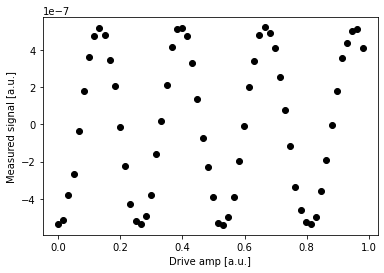

In [22]:

rabi_values = []
for i in range(60):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(result.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

In [23]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

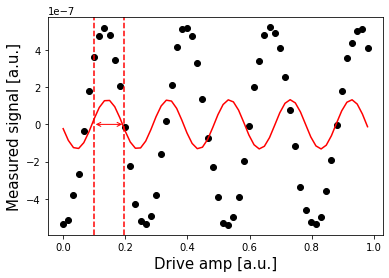

In [24]:
# Ora fitto questi dati con una sinusoide. Attenzione ai parametri di fit: cambiano notevolmente tra backend diversi
# e per durate di umpulso diverse.
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [-3e-7, 0.01, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
#plt.savefig('Amp_pi.png')
plt.show()

In [25]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.0982543600206152


In [26]:
# Definisco il mio impulso in base ai risultati appena ottenuti!!
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,        #Impulso gaussiano coi parametri ottenuti
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [27]:
# Ora creo un circuito che usa come X gate la mia calibrazione
qc = QuantumCircuit(1,1)
qc.x(0)
qc.measure(0,0)
qc.add_calibration('x', [0], pi_pulse)